<a href="https://colab.research.google.com/github/RicardoMenna/MachineLearningTP4/blob/main/TPN%C2%B04_Covid_19_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trabajo Práctico N°4**
**Ejercicio: Covid-19 Detection in Chest X-Ray Images**

In [163]:
"""Importaciones"""
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os import listdir
import pandas as pd
from sklearn.preprocessing import  StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm

**En primer lugar se descarga y descomprimen las imágenes**

In [1]:
# Descarga y descomprimir
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip

--2021-10-24 13:13:01--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/fvk7h5dg2p-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.61.200
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.61.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198985388 (190M) [application/octet-stream]
Saving to: ‘dataroot/fvk7h5dg2p-1.zip’

fvk7h5dg2p-1.zip    100%[===================>] 189.77M  27.6MB/s    in 7.7s    

2021-10-24 13:13:10 (24.5 MB/s) - ‘dataroot/fvk7h5dg2p-1.zip’ saved [198985388/198985388]



In [2]:
# Unzip
with zipfile.ZipFile(dataroot+"fvk7h5dg2p-1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

**Se realiza una visualización previa de las imágenes** 

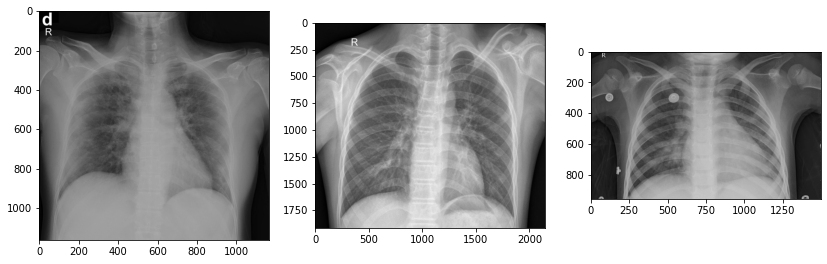

In [3]:

# Load and preview images
img_covid     = cv2.imread(dataroot+'COVID-19 cases/1-s2.0-S0929664620300449-gr2_lrg-d.jpg',0)
img_normal    = cv2.imread(dataroot+'Normal /IM-0011-0001-0001.jpeg',0)
img_pneumonia = cv2.imread(dataroot+'Pneumonia/person11_virus_38.jpeg',0)

plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(img_covid,cmap='gray')
plt.subplot(1,3,2)
plt.imshow(img_normal,cmap='gray')
plt.subplot(1,3,3)
plt.imshow(img_pneumonia,cmap='gray')

**Listo todas las imágenes correspondientes a cada caso. Le cambio el tamaño interpolando para que todas queden iguales**

In [170]:
#Listo los archivos de cada carpeta
lis_covid=listdir(dataroot+"COVID-19 cases/")
lis_normal=listdir(dataroot+"Normal /")
lis_pneumonia=listdir(dataroot+"Pneumonia/")

#Creo listas de ceros con el tamaño de cada lista anterior 
#En estas listas estarán los imágenes redimensionadas
lis_covid_res=[0]* len(lis_covid)
lis_normal_res=[0]* len(lis_normal)
lis_pneumonia_res=[0]* len(lis_pneumonia)

#En estas listas estarán los nombres de las imágenes
lis_covid_name=[0]* len(lis_covid)
lis_normal_name=[0]* len(lis_normal)
lis_pneumonia_name=[0]* len(lis_pneumonia)

#Le cambio la dimensión a las imagenes de Covid y las guardo en la lista correspondiente
for i in range(len(lis_covid)):
  img=cv2.imread(dataroot+"COVID-19 cases/"+lis_covid[i],0)
  img_covid_res=cv2.resize(img, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
  lis_covid_name[i]=lis_covid[i]
  lis_covid_res[i]=np.array(img_covid_res)

#Le cambio la dimensión a las imagenes Normal y las guardo en la lista correspondiente
for i in range(len(lis_normal)):
  img=cv2.imread(dataroot+"Normal /"+lis_normal[i],0)
  img_normal_res=cv2.resize(img, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
  lis_normal_name[i]=lis_normal[i]
  lis_normal_res[i]=np.array(img_normal_res)

#Le cambio la dimensión a las imagenes de Pneumonia y las guardo en la lista correspondiente
for i in range(len(lis_pneumonia)):
  img=cv2.imread(dataroot+"Pneumonia/"+lis_pneumonia[i],0)
  img_pneumonia_res=cv2.resize(img, dsize=(500, 500), interpolation=cv2.INTER_CUBIC)
  lis_pneumonia_name[i]=lis_pneumonia[i]
  lis_pneumonia_res[i]=np.array(img_pneumonia_res)



**Muestro las imágenes redimensionadas** 

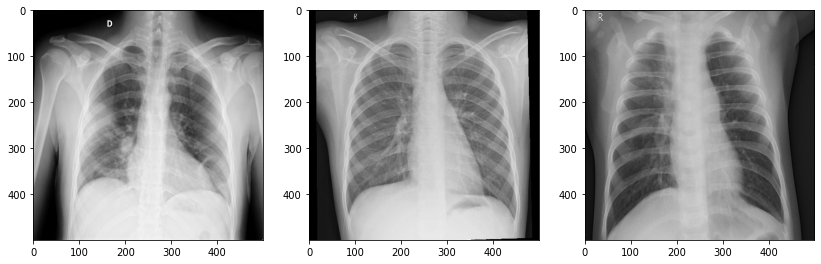

In [171]:
#Las imágenes mostradas no necesariamente coinciden con las anteriores mostradas
plt.figure(figsize=(14,14))
plt.subplot(1,3,1)
plt.imshow(lis_covid_res[10],cmap='gray')
plt.subplot(1,3,2)
plt.imshow(lis_normal_res[10],cmap='gray')
plt.subplot(1,3,3)
plt.imshow(lis_pneumonia_res[35],cmap='gray')

**Teniendo todas las imagenes del mismo tamaño separadas en diferentes listas, procedo a crear un dataframe con estos datos**

In [172]:
df_cov = pd.DataFrame({"Name": lis_covid_name, "Data": lis_covid_res, "Etiqueta": "Covid"})
df_nor = pd.DataFrame({"Name": lis_normal_name,"Data": lis_normal_res, "Etiqueta": "Normal"})
df_pne = pd.DataFrame({"Name": lis_pneumonia_name,"Data": lis_pneumonia_res, "Etiqueta": "Pneumonia"})

#Creo un DataFrame con todos los datos
df_temp= df_cov.append(df_nor,ignore_index="true")
df = df_temp.append(df_pne, ignore_index="true")
df.head(10)

,Name,Data,Etiqueta
0,fff49165-b22d-4bb4-b9d1-d5d62c52436c.annot.ori...,"[[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,...",Covid
1,1-s2.0-S1684118220300682-main.pdf-003-b1.png,"[[77, 77, 79, 80, 82, 86, 88, 89, 93, 96, 95, ...",Covid
2,jkms-35-e79-g001-l-a.jpg,"[[161, 62, 53, 80, 76, 76, 76, 77, 76, 76, 76,...",Covid
3,auntminnie-2020_01_31_20_24_2322_2020_01_31_x-...,"[[57, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, ...",Covid
4,1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Covid
5,35AF5C3B-D04D-4B4B-92B7-CB1F67D83085.jpeg,"[[109, 120, 136, 156, 179, 190, 194, 201, 205,...",Covid
6,2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg,"[[6, 7, 6, 4, 1, 3, 2, 3, 5, 6, 7, 7, 7, 5, 1,...",Covid
7,5CBC2E94-D358-401E-8928-965CCD965C5C.jpeg,"[[9, 8, 8, 8, 8, 8, 8, 7, 7, 8, 7, 7, 7, 7, 7,...",Covid
8,ryct.2020200034.fig5-day0.jpeg,"[[1, 5, 1, 2, 2, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,...",Covid
9,da9e9aac-de8c-44c7-ba57-e7cc8e4caaba.annot.ori...,"[[43, 43, 43, 43, 43, 43, 44, 44, 44, 45, 45, ...",Covid


In [184]:
# Numero de muestras:
n_samples = len(df.Data)
df.Data[1]
# Matriz de dígitos reformada
#data = df.reshape((n_samples, -1))
#print(data.shape)

array([[77, 77, 79, ..., 63, 60, 60],
       [79, 80, 81, ..., 67, 65, 64],
       [83, 86, 86, ..., 73, 70, 68],
       ...,
       [ 0,  0,  2, ...,  3,  3,  3],
       [ 0,  0,  2, ...,  2,  3,  3],
       [ 0,  0,  3, ...,  2,  3,  3]], dtype=uint8)

**Ahora divido los datos para entrenamiento y testeo**

In [173]:
#Divido el conjunto de datos en subconjuntos de entrenar y probar:
X_train, X_test, y_train, y_test = train_test_split(df.Data, df.Etiqueta, train_size=0.8, random_state=1)
# Entrenar 80% y probar 20%
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(482,)
(482,)
(121,)
(121,)


**Entreno al clasificador.**

In [176]:
# Clasificador de soportes vectoriales
clasificador = svm.SVC(gamma=0.001)
# Aprenda a clasificar el conjunto de entrenamiento
clasificador.fit(X_train, y_train)

ValueError: ignored